In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12,4)

weat = pd.read_csv('weatherAUS.csv')
weat.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday', 'RainTomorrow'],
      dtype='object')

# 1. 정형데이터마이닝
- weatherAUS
    - 날짜형 : 'Date'
    - 범주형 : 'Location','WindGustDir','WindDir9am', 'WindDir3pm','Cloud9am', 'Cloud3pm','RainToday', 'RainTomorrow'
    - 수치형 : 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm',


#### 1.
- NA값이 10000개 이상인 열 제외
- NA값이 있는 행 제거
- Date형 특성의 값들을 Data형으로 변환
- 데이터를 7:3으로 분할

In [22]:
data1 = weat.copy()

# NA값이 10000개 이상인 열 제외
na_count = data1.isnull().sum()
cols_over_10000 = na_count[na_count >= 10000].index.to_list()
data1 = data1.drop(cols_over_10000, axis=1)

# NA값이 있는 행 제거
data1 = data1.dropna()

# Date형 특성의 값들을 Data형으로 변환
data1.Date = data1.Date.astype(dtype='datetime64[ns]')

# 모델 적용을 위해 문자형 특성들을 모두 LabelEncoding
from sklearn.preprocessing import LabelEncoder

cols_obj = data1.select_dtypes('object').columns

for col in cols_obj:
    le = LabelEncoder()
    col_en = col+'_en'
    data1[col_en] = le.fit_transform(data1[col])
    data1.drop([col], inplace=True, axis=1)

# 데이터를 7:3으로 분할
X= data1.drop(['RainTomorrow_en','Date'], axis=1)
y= data1.RainTomorrow_en

#### 2.
- train 데이터로 Rainbox를 예측하는 분류모델을 3개 이상 생성. test 데이터에 대한 예측값을 csv로 제출
    - 아래 모델을 사용하여 GridSearchCV로 적정파라미터를 탐색 후 최적화 모델을 선정한다.
        - LogisticRegression
        - SVM
        - XGBoost
        - RandomForestClassifier

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

lr_cv = StratifiedKFold(n_splits=4)
lr_model = LogisticRegression()
lr_grid = { 'penalty' : ['l2'],
            'C' : [0.5, 1, 1.5],
            'solver' : ['lbfgs','liblinear'],
            'max_iter' : [1000, 1500]}

#cv = GridSearchCV(lr_model, param_grid=lr_grid, cv=lr_cv, n_jobs=-1)
#cv.fit(X, y)
#print('Best scores : {:.3f}'.format(cv.best_score_))
#print('Best params : {}'.format(cv.best_params_))

# 직접 학습
model_lr = LogisticRegression(C=0.5, max_iter=1000, penalty='l2', solver='liblinear')
model_lr.fit(X_train, y_train)
print('score : {:.3f}'.format(model_lr.score(X_test, y_test)))

score : 0.846


In [25]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

svm_cv = StratifiedKFold(n_splits=4)
svm_model = SVC()
svm_grid = { 'degree': [1, 2, 3],                   # 'poly' 커널에서 차수 조절
             'C': [0.1, 1, 10],                     # 에러율 조절 (커지면 과적합)
             'gamma': [0.1, 1],                 # 학습정도 조절 (커지면 과적합)
             'kernel': ['linear', 'rbf', 'poly']}   # 경계면의 곡선화   

# 데이터가 180만 건. 파라미터 1set 학습도 2시간 이상 소요됨
#svm_gcv = GridSearchCV(svm_model, param_grid=svm_grid, cv=svm_cv, n_jobs=-1)
#svm_gcv.fit(X, y)
#print('best score : {:.3f}'.format(svm_gcv.best_score_))
#print('best parameter : {}'.format(svm_gcv.best_params_))

# 직접 학습
#svm_model = SVC(degree=3, C=0.1, gamma=0.5, kernel='poly', verbose=True)
#svm_model.fit(X_train, y_train)
#print('best score : {:.3f}'.format(svm_model.score(X_test, y_test)))

In [26]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc_cv = StratifiedKFold(n_splits=4)
rfc_model = RandomForestClassifier()
rfc_grid = {    'n_estimators': [200, 500, 800],
                'max_features': ['auto', 'sqrt'],
                'max_depth': [5, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]}

# 데이터가 180만 건. 파라미터 1set 학습도 2시간 이상 소요됨
#rfc_gcv = GridSearchCV(rfc_model, param_grid=rfc_grid, cv=rfc_cv, n_jobs=-1)
#rfc_gcv.fit(X, y)
#print('best scores : {:.3f}'.format(rfc_gcv.best_score_))
#print('best parameter:{}'.format(rfc_gcv.best_params_))

# 직접 학습
model_rfc = RandomForestClassifier(n_estimators=100)
model_rfc.fit(X_train, y_train)
print('score : {:.3f}'.format(model_rfc.score(X_test, y_test)))

score : 0.855


In [27]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

xgb_cv = StratifiedKFold()
xgb_model = XGBClassifier()
xgb_grid = {
    'n_estimators': [100, 300],
    'max_depth':[5, 10],
    'learning_rate':[0.05,0.1,0.15],
    'min_child_weight':[1,2,3],
    'booster':['gbtree','gblinear'],
    }

#xgb_gcv = GridSearchCV(xgb_model, param_grid=xgb_grid, cv=xgb_cv, n_jobs=-1, verbose=True)
#xgb_gcv.fit(X, y)
#print('best score : {:.3f}'.format(xgb_cv.best_score_))
#print('best parameter:{}'.format(xgb_gcv.best_params_))

# 직접 학습
model_xgb = XGBClassifier(n_estimators=100, learning_rate=0.05)
model_xgb.fit(X_train, y_train)
print("score : {:.3f}".format(model_xgb.score(X_test, y_test)))

score : 0.856


#### 3.
- 3개 분류모델에 대해 성과분석 실시. 정확도 비교하여 설명하시오. ROC curve를 그리고 AUC값을 산출하시오.

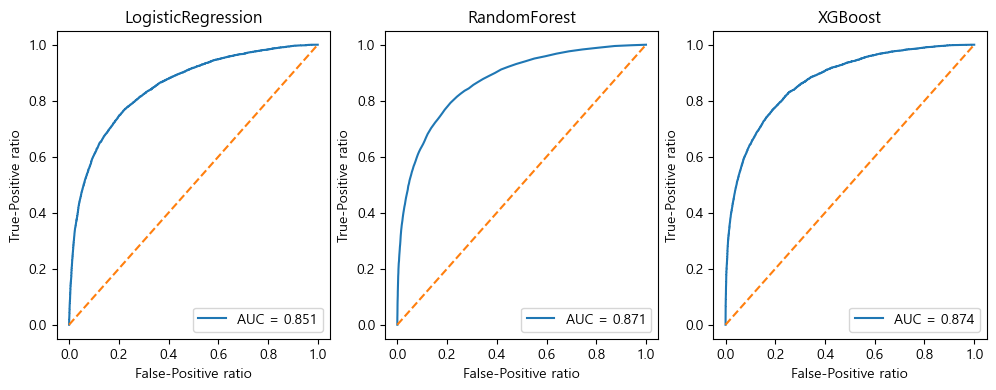

In [40]:
from sklearn.metrics import roc_curve, auc

models = [model_lr, model_rfc, model_xgb]
model_names = ['LogisticRegression', 'RandomForest', 'XGBoost']

def plot_roc_curve(name, ax, y, prob):
    # fpr, tpr값을 구한다.    
    fpr, tpr, _ = roc_curve(y, prob[:,1])
    # AUC 계산하기
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlabel('False-Positive ratio')
    ax.set_ylabel('True-Positive ratio')
    ax.set_title(name)
    ax.legend(loc='lower right')

figure, axs = plt.subplots(1,3)
for model, name, ax in zip(models, model_names, axs):
    prob = model.predict_proba(X_test)
    plot_roc_curve(name, ax, y_test, prob)


# 2. 통계분석
- bike_marketing
    - 범주형 : 'pop_density'
    - 수치형 : 'company_num', 'google_adwords', 'facebook', 'twitter',
       'marketing_total', 'revenues', 'employees'


In [42]:
bike = pd.read_csv('bike_marketing.csv')
bike.columns

Index(['company_num', 'google_adwords', 'facebook', 'twitter',
       'marketing_total', 'revenues', 'employees', 'pop_density'],
      dtype='object')

#### 1. 
- pop_density 변수를 범주형으로 변환
- pop_density 별 revenues의 평균차이가 있는지 통계분석 시행, 결과분석
- 대립가설이 채택된다면 사후분석 실시, 결과 해석

stat: 0.610, p-value 0.545
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   1.1119 0.5578 -1.4359 3.6596  False
     1      3   0.8642 0.7023 -1.6836 3.4119  False
     2      3  -0.2477 0.9746   -2.96 2.4646  False
---------------------------------------------------


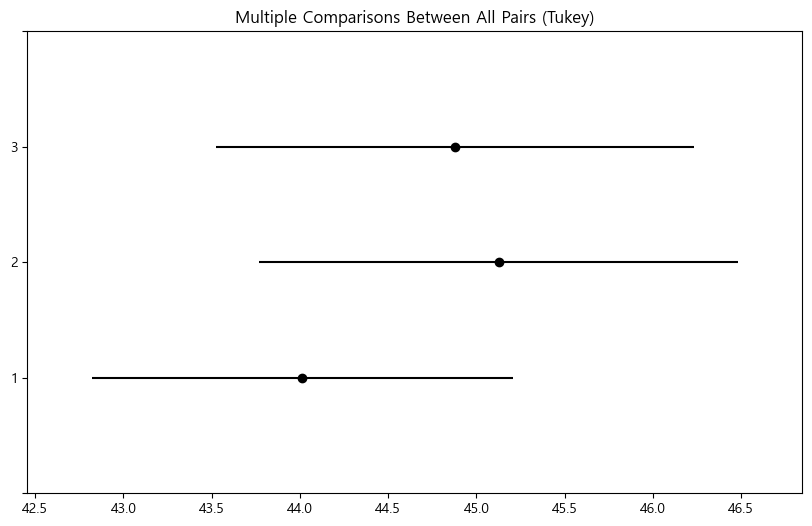

In [79]:
data2 = bike.copy()

# pop_density 변수를 범주형으로 변환
density = {'Low':1, 'Medium':2, 'High':3}
data2.pop_density = data2.pop_density.map(density)

# 분산분석 수행
from statsmodels.stats.oneway import anova_oneway
oa = anova_oneway(data = data2.revenues, groups=data2.pop_density, use_var='equal')
print('stat: {:.3f}, p-value {:.3f}'.format(oa.statistic, oa.pvalue))

# 분산분석 결과 
# 비교해야 할 그룹이 3개이므로 분산분석을 수행한다. 분산분석에서의 가정은 다음과 같다.
    # 귀무가설: pop_denstiy 그룹에 따른 revenues의 평균은 차이가 없다.
    # 대립가설: pop_denstiy 그룹에 따른 revenues의 평균은 차이가 있다.
# 분산분석 결과 F통계량은 0.610이고 p-value는 0.545로 대립가설은 기각한다. 따라서,
# pop_denstiy 그룹에 따른 revenues의 평균은 통계적으로 유의한 차이가 없다.


# 사후검정
from statsmodels.sandbox.stats.multicomp import MultiComparison
from scipy.stats import ttest_ind

mc= MultiComparison(data=data2.revenues, groups=data2.pop_density).tukeyhsd(alpha=0.05)
print(mc)

mc.plot_simultaneous()
plt.show()

#### 2.
- 'google_adwords', 'facebook', 'twitter', 'marketing_total', 'employees'가 revenues에 영향을 미치는지 알아보는 회귀분석을 전진선택법을 사용하여 수행하고 결과를 해석하시오.

In [82]:
import statsmodels.api as sm
from itertools import combinations

def stepwise_method_AIC(X, y):
    result = pd.DataFrame()
    feature_combis = []
    for i in range(1, len(X.columns)+1):
        feature_combis += list(combinations(X.columns,i))
    feature_combis.reverse()

    for j, combi in enumerate(feature_combis):
        X_ = X.filter(combi)
        X_ = sm.add_constant(X_)

        model = sm.OLS(y, X_)
        fitted = model.fit()

        result.loc[j, 'feature_combi'] = ', '.join(list(fitted.params.keys()))
        result.loc[j,'AIC'] = fitted.aic

        result = result.sort_values(by='AIC', ascending=True)
        best = result.iloc[0,0]
    return best, result

X = data2[['google_adwords', 'facebook', 'twitter', 'marketing_total', 'employees']]
y = data2.revenues

best, result = stepwise_method_AIC(X, y)

print('total feature: ', X.columns)
print('best feature'' set: ', best)
print(result)

total feature:  Index(['google_adwords', 'facebook', 'twitter', 'marketing_total',
       'employees'],
      dtype='object')
best feature set:  const, google_adwords, facebook, twitter, marketing_total, employees
                                        feature_combi          AIC
0   const, google_adwords, facebook, twitter, mark...   750.515872
13         const, google_adwords, facebook, employees   750.875361
4   const, google_adwords, facebook, twitter, empl...   752.812055
3   const, google_adwords, facebook, marketing_tot...   752.825569
1   const, facebook, twitter, marketing_total, emp...   753.118042
2   const, google_adwords, twitter, marketing_tota...   754.175228
5   const, google_adwords, facebook, twitter, mark...   762.205908
25                    const, google_adwords, facebook   763.765590
15           const, google_adwords, facebook, twitter   765.539335
14   const, google_adwords, facebook, marketing_total   765.568535
9           const, facebook, twitter, marketing_t

#### 3.
- 전진선택법 결과 선택된 특성으로 결정된 회귀모형에 대해 잔차분석 및 결과 해석

In [87]:
model = sm.OLS(y, sm.add_constant(X))
fitted  = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               revenues   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     228.9
Date:                Mon, 08 Sep 2025   Prob (F-statistic):           1.57e-72
Time:                        00:50:12   Log-Likelihood:                -369.26
No. Observations:                 172   AIC:                             750.5
Df Residuals:                     166   BIC:                             769.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              28.4433      0.596     47.706      0.000      27.266      29.621
google_adwords      1.2110      0.571      2.122      0.035       0.084       2.338
facebook            1.3464      0.571      2.356      0.020       0.218       2.474
twitter             1.1724      0.571      2.052      0.042       0.045       2.300
marketing_total    -1.1696      0.571     -2.049      0.042      -2.297      -0.043
employees           0.3865      0.104      3.708      0.000       0.181       0.592
==============================================================================
Omnibus:                        3.945   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.974
Skew:                          -0.341   Prob(JB):                        0.137
Kurtosis:                       2.702   Cond. No.                     2.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

정규성 확인 ------------------------------ 
Jarque-bera stats 3.974 , p-value 0.137
Skewness -0.341, Kurtosis 2.702


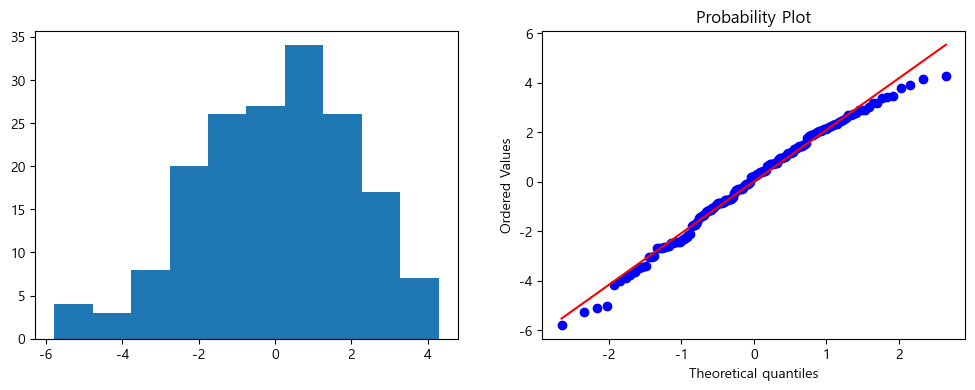

등분산성 확인 ------------------------------ 


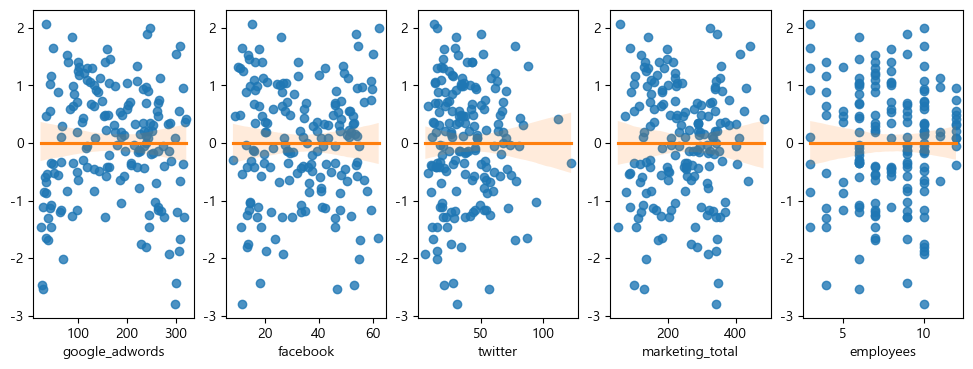

독립성 확인 ------------------------------ 
durbin-watson stats 2.111


In [99]:
#-----------------------------------------------------------------
# 잔차 분석
#-----------------------------------------------------------------
import seaborn as sns
from scipy.stats import zscore, probplot
from statsmodels.stats.stattools import jarque_bera, durbin_watson

resid = fitted.resid
pred = fitted.fittedvalues
sresid = zscore(resid)

print('정규성 확인 ------------------------------ ')

stats, p, skew, kurt = jarque_bera(resid)
print('Jarque-bera stats {:.3f} , p-value {:.3f}'.format(stats, p))
print('Skewness {:.3f}, Kurtosis {:.3f}'.format(skew, kurt))

fig, ax= plt.subplots(1, 2)
ax[0].hist(resid)
probplot(resid, plot=ax[1])
plt.show()

print('등분산성 확인 ------------------------------ ')

cols = X.columns
fig, ax = plt.subplots(1,5)
for feature, ax, in zip(cols, ax.ravel()):
    sns.regplot(x=X[feature], y=sresid, line_kws={'color':'C1'}, ax=ax)
plt.show()

print('독립성 확인 ------------------------------ ')

dw = durbin_watson(resid)
print('durbin-watson stats {:.3f}'.format(dw))



In [95]:
cols

['google_adwords', 'facebook', 'twitter', 'marketing_total', 'employees']

# 3. 통계분석
- instagram_태교여행.txt

In [100]:
f = open('instagram_태교여행.txt')
ins = f.read()

'쇼퍼걸  예비맘 태교여행 괌 임신6개월 배 부르게 밥 먹고 오빠 생일선물 산다고 다니다가 뜻밖에 내 가방도 득템 가방더 안실려고했는데   앙  기분 완전 좋음   이제 렌트하고 돌아댕기야지  \n태교여행  몰디브 한식을 꼭 먹어야 했었던 임산부 땜에 남편은 몰디브에서도 김치찌개를 끓였어야 했다.\n하음이가 사랑이 뱃속에 있은 지 임신4개월째 여행가서 찍은 사진. 여행이라고는 하지만 온통 머릿속은 사랑이 건강과 더불어 6개월 후 빛을 볼 하음이에 쏠려 있어 시드니의 분위기와 풍경보다는 우리 둘의 시간에 집중했던.  sidney  부부  태교여행  호주  시드니  오페라하우스  아이고 멋져라  임신4개월\n행복했던  제주여행 화창한 날씨. 푸르른 바다. 맑고 쾌청한 하늘 나는 오늘  바다 와 깔맞춤. .블루뚜ㅋㅋ instadaily daily dailylook selfie 셀피 제주도 용머리해안 힐링 바다스타그램 임산부 태교여행 폭스베스트 겨울코디 뚜뚜 뚜뚜네\n떠나자  오키나와 @hyeni__twinkle 별똥이와 함께 떠나는 호야와 혜니의 태교여행 supreme  supremetnf  supremeundercover  nmc  pumphoya  슈프림  섭리미  슈노  슈노캐리어  슈언코치  나매  슈매  펌프호야  태교여행  오키나와\n어제 아침 - 양치만하고 수영하러 사진찍는데 방해되니까 비켜주세요 토리아빠  괌 guam 태교여행 여행스타그램 예비맘 닭띠맘 셀스타그램 셀카 여유로운아침\n 까오지에서 식사했는데 식당앞에서 찍은것도 아니고 건너편에서 사진찍기 ㅋ ㅋ 대만첫날 20161206 대만 타이베이 대만여행 가족여행 먹방여행 태교여행 여행 여행스타그램 얼스타그램 임산부스타그램 젊줌마 동먼 융캉제 럽스타그램 줌마그램 소통 좋아요\n이때는 한방이 5주차였을때 겁도 없이 발리여행 2주나했었다니. 이제는 만삭여행준비 시간 너무 빨리가  마음의준비할 시간도 없이 훅훅  태교여행  괌\n맛있겠죠오 넘사랑하는 유월 아침조식 제주도에서 가장 애정하는 곳이에요 저안에 

#### 1.
- 숫자, 특수문자등을 제거하는 전처리 작업 시행
- 전처리된 데이터에서 태교여행이라는 단어를 사전에 추가하고, 명사를 추출해, 출현빈도 10위까지 막대그래프 시각화
- 전처리된 데이터를 이용하여 워드클라우드 작성

In [111]:
import re

data3 = re.sub(r'[^\uAC00-\uD7A3a-zA-Z\s]', ' ', ins)
corpus = data3.split()

#### 2.
- 전처리된 데이터에서 태교여행이라는 단어를 사전에 추가하고, 명사를 추출해, 출현빈도 10위까지 막대그래프 시각화

<Axes: xlabel='noun'>

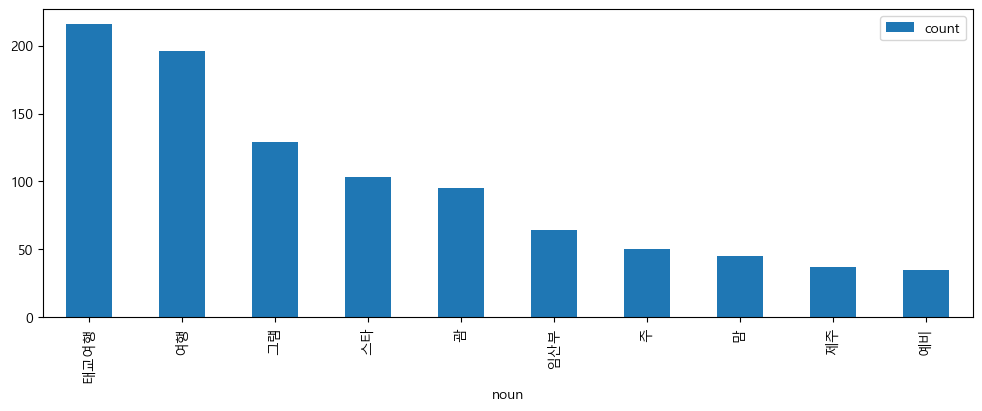

In [110]:
from konlpy.tag import Okt
from collections import Counter

okt = Okt()
noun = okt.nouns(data3)
morph = okt.morphs(data3)

noun_count=Counter(noun)
morph_count=Counter(morph)

df_ko=pd.DataFrame({'noun':noun_count.keys(), 'count':noun_count.values()})
df_ko.sort_values(by='count', ascending=False, inplace=True)

df_ko.head(10).plot(kind='bar',x='noun', y='count')

#### 3.
- 전처리된 데이터를 이용하여 워드클라우드 작성

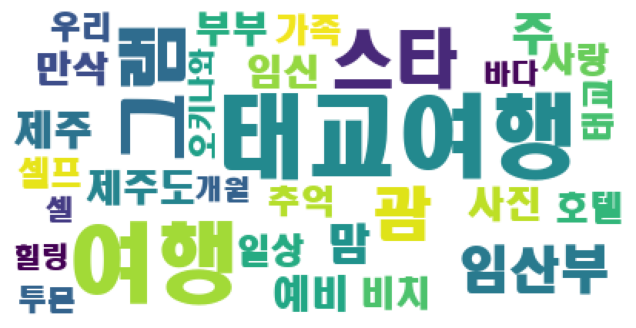

In [112]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C://windows//Fonts//HMKMRHD.ttf', background_color='white', max_font_size=60)
cloud = wc.generate_from_frequencies(dict(noun_count.most_common(30)))

plt.axis('off')
plt.imshow(cloud)
plt.show()